In [1]:
"""
Optimization
    - reducing the number of pixels used
        - binning routine
    - absorption model is as optimized as I can get. Tried furter vectorization, but the program was slower
    - reduce the number of iterations for the optimization algorithm

file:
/net/dials/raid1/sauter/bernina/spectrum_masters/run_000795.JF07T32V01_master.h5

Vanessa converted the first frame to a cbf and put it at
/net/cci/voklejas/repos/dials/build/dials_data/converted.cbf

fun: 1010.2351576806018
hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.05170477,  0.03348077, -0.00093223])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 104
      nit: 17
     njev: 26
   status: 0
  success: True

        x: array([4.77773921, 0.03740667, 1.57035911])
                  4.64695057, 0.03448264, 1.46030686
"""

"\nOptimization\n    - reducing the number of pixels used\n        - binning routine\n    - absorption model is as optimized as I can get. Tried furter vectorization, but the program was slower\n    - reduce the number of iterations for the optimization algorithm\n\nfile:\n/net/dials/raid1/sauter/bernina/spectrum_masters/run_000795.JF07T32V01_master.h5\n\nVanessa converted the first frame to a cbf and put it at\n/net/cci/voklejas/repos/dials/build/dials_data/converted.cbf\n\nfun: 1010.2351576806018\nhess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>\n      jac: array([-0.05170477,  0.03348077, -0.00093223])\n  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'\n     nfev: 104\n      nit: 17\n     njev: 26\n   status: 0\n  success: True\n\n        x: array([4.77773921, 0.03740667, 1.57035911])\n"

In [1]:
import sys
sys.path.append('/home/david/dials_dev/modules/dxtbx/src')
sys.path.append('/home/david/dials_dev/build/lib')
sys.path.append('/home/david/dials_dev/modules')
from cctbx import factor_kev_angstrom
from dials.array_family import flex
import dxtbx
#from dxtbx.model.experiment_list import ExperimentListFactory
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import time

import Modules_Multipanel as MOD


mpl.rc_file('matplotlibrc.txt')

In [2]:
image_file_name = '/home/david/Documents/Background/Data/converted.cbf'
image = dxtbx.load(image_file_name)
beam = image.get_beam()
wavelength = beam.get_wavelength()
data = image.get_raw_data()
detector = image.get_detector()
pixel_size = detector[0].get_pixel_size()[0]
kapton_absorption_length = MOD.get_absorption_correction()(wavelength)

In [3]:
angle = 265 * np.pi/180
h = 0.04
f = 1.5
t = 0.025
f_range = 0.1
polarization_fraction = 0.85

In [4]:
def GetModel(angle, h, f, t, s_norm):
    length = s_norm.shape[0]
    path_length = np.zeros(length)
    
    n1 = -h * np.array((0, 1, 0)).T 
    n2 = -(h + t) * np.array((0, 1, 0)).T
    n3 = f * np.array((0, 0, 1)).T
    Rz = np.array((
        (np.cos(angle), -np.sin(angle), 0),
        (np.sin(angle), np.cos(angle), 0),
        (0, 0, 1)
        ))
    n1 = np.matmul(Rz, n1)
    n2 = np.matmul(Rz, n2)
    n3 = np.matmul(Rz, n3)  
    
    L1 = np.divide(np.linalg.norm(n1)**2, np.matmul(s_norm, n1))
    L2 = np.divide(np.linalg.norm(n2)**2, np.matmul(s_norm, n2))
    L3 = np.divide(np.linalg.norm(n3)**2, np.matmul(s_norm, n3))
     
    indices1 = np.logical_and(
        L1 < L3,
        L2 >= L3
        )
    indices2 = np.logical_and(
        L3 > L2 ,
        L2 >= 0
        )
    
    path_length[indices1] = L3[indices1] - L1[indices1]
    path_length[indices2] = L2[indices2] - L1[indices2]
    return path_length

    
def IntegrateModel(angle, h, f, t, s_norm, kapton_absorption_length, f_range, n=3):
    length = s_norm.shape[0]
    path_length_int = np.zeros((length, n))
    f_int = np.linspace(f - f_range, f + f_range, n)
    df = f_int[1] - f_int[0]
    
    n1 = -h * np.array((0, 1, 0)).T 
    n2 = -(h + t) * np.array((0, 1, 0)).T
    Rz = np.array((
        (np.cos(angle), -np.sin(angle), 0),
        (np.sin(angle), np.cos(angle), 0),
        (0, 0, 1)
        ))
    n1 = np.matmul(Rz, n1)
    n2 = np.matmul(Rz, n2)

    L1 = np.divide(np.linalg.norm(n1)**2, np.matmul(s_norm, n1))
    L2 = np.divide(np.linalg.norm(n2)**2, np.matmul(s_norm, n2))
    
    for index, f_here in enumerate(f_int):
        n3 = f_here * np.array((0, 0, 1)).T
        n3 = np.matmul(Rz, n3)  
        L3 = np.divide(np.linalg.norm(n3)**2, np.matmul(s_norm, n3))
        indices1 = np.logical_and(
            L1 < L3,
            L2 >= L3
            )
        indices2 = np.logical_and(
            L3 > L2 ,
            L2 >= 0
            )
        path_length_int[indices1, index] = L3[indices1] - L1[indices1]
        path_length_int[indices2, index] = L2[indices2] - L1[indices2]
    path_length = np.trapz(path_length_int, f_int, axis=-1) / (f_int[-1] - f_int[0])
    return MOD.GetAbsorption(path_length, kapton_absorption_length)

In [5]:
def Fit(params, t, normalized_image, s_norm, kapton_absorption_length, weights):
    angle = params[0]
    h = params[1]
    f = params[2]
    absorption = IntegrateModel(angle, h, f, t, s_norm, kapton_absorption_length, 0.1, n=3)
    residuals = weights * (normalized_image - absorption)
    print(angle * 180/np.pi)
    print(h)
    print(f)
    print(np.linalg.norm(residuals))
    print()
    return np.linalg.norm(residuals)

In [6]:
def ProcessPanelFlat_Old(data, panel):
    panel_shape = panel.get_image_size()
    I = data.as_numpy_array().flatten()
    mask = np.zeros(panel_shape, dtype=np.bool)
    pad = 5
    mask[:pad, :] = True
    mask[-pad:, :] = True
    mask[:, :pad] = True
    mask[:, -pad:] = True
    mask = mask.flatten()
    mask = np.logical_or(
        mask,
        I <= 0
        )
    mask = np.logical_or(
        mask,
        I >= 800
        )    
    x, y = np.meshgrid(
        np.linspace(0, panel_shape[0] - 1, panel_shape[0]),
        np.linspace(0, panel_shape[1] - 1, panel_shape[1])
        )
    mm = panel.pixel_to_millimeter(flex.vec2_double(
        flex.double(x.flatten()),
        flex.double(y.flatten())
        ))
    s = panel.get_lab_coord(mm).as_numpy_array()
    
    s_norm = (s.T / np.linalg.norm(s, axis=1)).T
    s_norm[:, 2] *= -1
    return I, s, s_norm, mask

In [43]:
def ProcessPanelFlat(data, panel):
    panel_shape = panel.get_image_size()
    x, y = np.meshgrid(
        np.linspace(0, panel_shape[0] - 1, panel_shape[0]),
        np.linspace(0, panel_shape[1] - 1, panel_shape[1])
        )
    mm = panel.pixel_to_millimeter(flex.vec2_double(
        flex.double(x.flatten()),
        flex.double(y.flatten())
        ))
    s = panel.get_lab_coord(mm).as_numpy_array()
    mask = np.zeros(panel_shape, dtype=np.bool)
    pad = 5
    mask[:pad, :] = True
    mask[-pad:, :] = True
    mask[:, :pad] = True
    mask[:, -pad:] = True
    mask = mask.flatten()
    I = data.as_numpy_array().flatten()
    mask = np.logical_or(
        mask,
        I <= 0
        )
    mask = np.logical_or(
        mask,
        I >= 800
        )
    weights = np.ones(mask.size)
    
    if np.invert(mask).sum() == 0:
        pass
    elif I[mask].mean() / I[mask].std() < 0.1:
        mask = np.ones(mask.shape, dtype=np.bool)
    elif I[mask].mean() / I[mask].std() > 5:
        mask = np.ones(mask.shape, dtype=np.bool)
    elif s[:, 0].mean() > 10:# or s[:, 0].mean() < -100:
        I[0] = I[np.invert(mask)].mean()
        s[0, :] = s[np.invert(mask), :].mean(axis=0)
        mask = np.ones(panel_shape, dtype=np.bool).flatten()
        mask[0] = False
        weights[0] = np.invert(mask).sum()
    
    s_norm = (s.T / np.linalg.norm(s, axis=1)).T
    s_norm[:, 2] *= -1
    
    return I, s, s_norm, mask, weights

In [44]:
def GetImageFlat(data, detector, polarization_fraction):
    I = np.zeros(16*16*254*254)
    s = np.zeros((16*16*254*254, 3))
    s_norm = np.zeros((16*16*254*254, 3))
    mask = np.zeros(16*16*254*254, dtype=np.bool)
    weights = np.zeros(16*16*254*254)
    for index in range(16*16):
        I_panel, s_panel, s_norm_panel, mask_panel, weights_panel\
            = ProcessPanelFlat(data[index], detector[index])
        start = index * 254*254
        end = (index + 1) * 254*254
        I[start: end] = I_panel
        s[start: end] = s_panel
        s_norm[start: end] = s_norm_panel
        mask[start: end] = mask_panel
        weights[start: end] = weights_panel
    mask = np.logical_or(
        mask,
        I <= 0
        )
    I = np.delete(I, mask)
    s = np.delete(s, mask, axis=0)
    s_norm = np.delete(s_norm, mask, axis=0)
    weights = np.delete(weights, mask)
    R = np.sqrt(s[:, 0]**2 + s[:, 1]**2)
    theta2 = np.arctan(R / np.abs(s[:, 2]))
    phi = np.pi + np.arctan2(s[:, 1], s[:, 0])
    polarization = (1 - polarization_fraction*np.cos(2*phi)*np.sin(theta2)**2 / (1+np.cos(theta2)**2))
    theta2_int = np.linspace(0, 60, 121) * np.pi/180
    
    integration_sum = np.histogram(
        theta2,
        bins=theta2_int,
        weights=I
        )
    integration_counts = np.histogram(
        theta2,
        bins=theta2_int
        )
    bins = integration_counts[1]
    bin_centers = (bins[1:] + bins[:-1])/2
    integrated = integration_sum[0] / integration_counts[0]
    indices = np.invert(np.isnan(integrated))
    integrated_image = np.interp(theta2, bin_centers[indices], integrated[indices])
    return I, s, s_norm, theta2, phi, polarization, integrated_image, weights

In [45]:
I, s, s_norm, theta2, phi, polarization, integrated_image, weights\
    = GetImageFlat(data, detector, polarization_fraction)
normalized_image = I / (polarization * integrated_image)

/tmp/ipykernel_6220/3407890164.py:42: RuntimeWarning: invalid value encountered in true_divide
  integrated = integration_sum[0] / integration_counts[0]


In [49]:
angle = 270 * np.pi/180
h = 0.04
f = 0.6
t = 0.025
f_range = 0.1

results_fit = minimize(
    Fit,
    x0=(angle, h, f),
    args=(t, normalized_image, s_norm, kapton_absorption_length, weights),
    method='L-BFGS-B',
    bounds=((0, 2*np.pi), (0.01, None), (0.2, None)),
    options={'ftol': 1e-09}
    )
angle_fit = results_fit.x[0]
h_fit = results_fit.x[1]
f_fit = results_fit.x[2]
print(results_fit)

270.0
0.04
0.6
659.1706277214599

270.0000005729578
0.04
0.6
659.1706275008687

270.0
0.04000001
0.6
659.1706288708085

270.0
0.04
0.60000001
659.1706276423058

281.1526606369784
0.03628244645434054
1.5808655895915291
670.5988954094223

281.1526612099362
0.03628244645434054
1.5808655895915291
670.5988956155372

281.1526606369784
0.03628245645434054
1.5808655895915291
670.5988925884174

281.1526606369784
0.03628244645434054
1.580865599591529
670.598895500583

271.72784148597856
0.03942405283800715
0.7519619679133559
658.3979147984469

271.72784205893635
0.03942405283800715
0.7519619679133559
658.39791490177

271.72784148597856
0.03942406283800715
0.7519619679133559
658.3979149488913

271.72784148597856
0.03942405283800715
0.751961977913356
658.3979148009067

270.9647649777439
0.03350828467527024
0.6907181445526203
658.0989824023602

270.9647655507017
0.03350828467527024
0.6907181445526203
658.0989825437692

270.9647649777439
0.03350829467527024
0.6907181445526203
658.098982802563

270.9

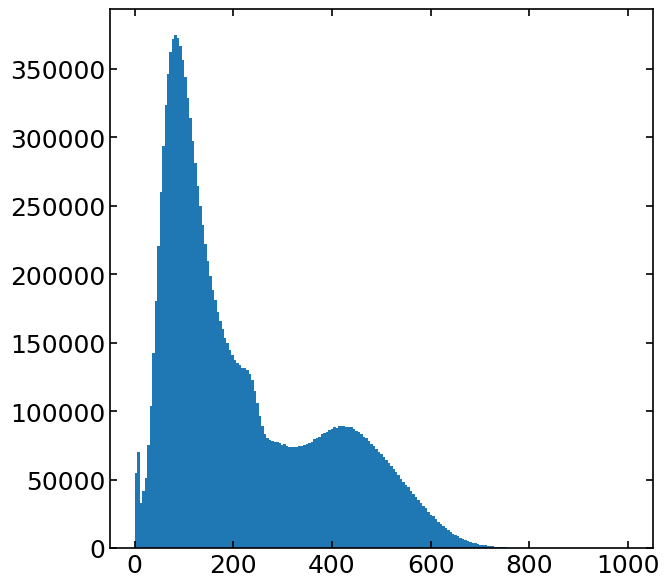

In [25]:
bins = np.linspace(0, 1000, 200)
centers = (bins[1:] + bins[:-1]) / 2
hist = np.histogram(I, bins=bins)
fig, axes = plt.subplots(1, 1)
axes.bar(centers, hist[0], width=(bins[1]-bins[0]))
plt.show()

absorption = MOD.IntegrateModel(angle_fit, h_fit, f_fit, t, s_norm, kapton_absorption_length, f_range, n=3)
absorption[mask] = -1
